In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz
import sklearn

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, manifold, ensemble, decomposition
from time import time

pd.set_option('display.max_columns', None)
%matplotlib inline
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics
results_path = str(Path(os.getcwd()).parents[1]) + "/results/random_forests/"

In [ ]:
# Example of using ColumnTransformer
data = pd.DataFrame({'Name' : [3, 4,6], 'Age' : [18, 92,98], 'Weight' : [68, 59,49]})

col_names = ['Name', 'Age', 'Weight']
features = data[col_names]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Age', 'Weight'])
    ], remainder='passthrough')

ct.fit_transform(features)

In [2]:
import importlib
importlib.reload(evaluation)
importlib.reload(helper);
importlib.reload(sns);

## Missing Data Analysis

This package is a great way to visualize missing data, we can see here that Gene_Ihc_ATRX is missing from most of the observations for example. Below we have two ways to visualize the amount of missing data for each feature

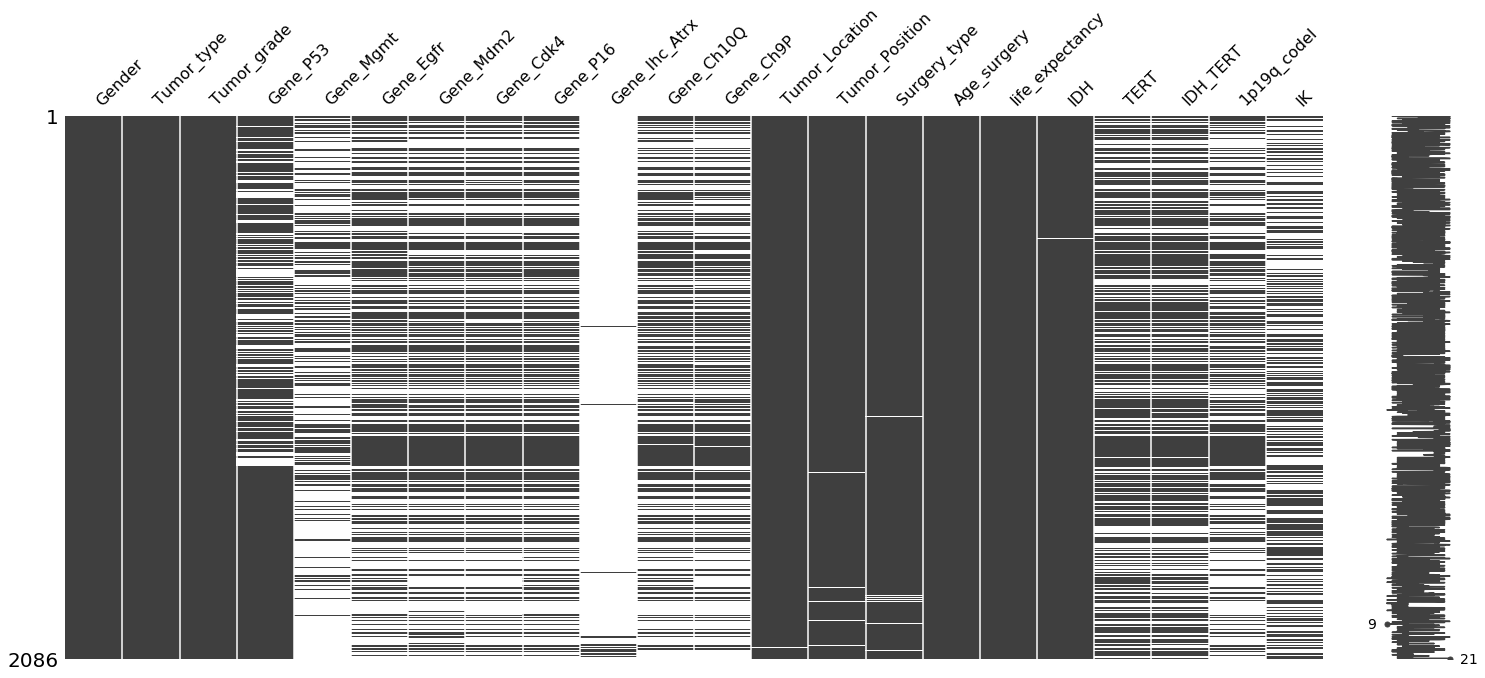

In [9]:
# Below missing data file 
PROCESSED_DATA_FILE = os.path.join(IMC_basedir, 'data/imputation_dataset_no_censoring_24022018.csv')

# Use missingno package to visualize missing data
df_md = pd.read_csv(PROCESSED_DATA_FILE)
import missingno as msno
fig = msno.matrix(df_md,inline=False);
plt.savefig(results_path + "missing_data_visualization")

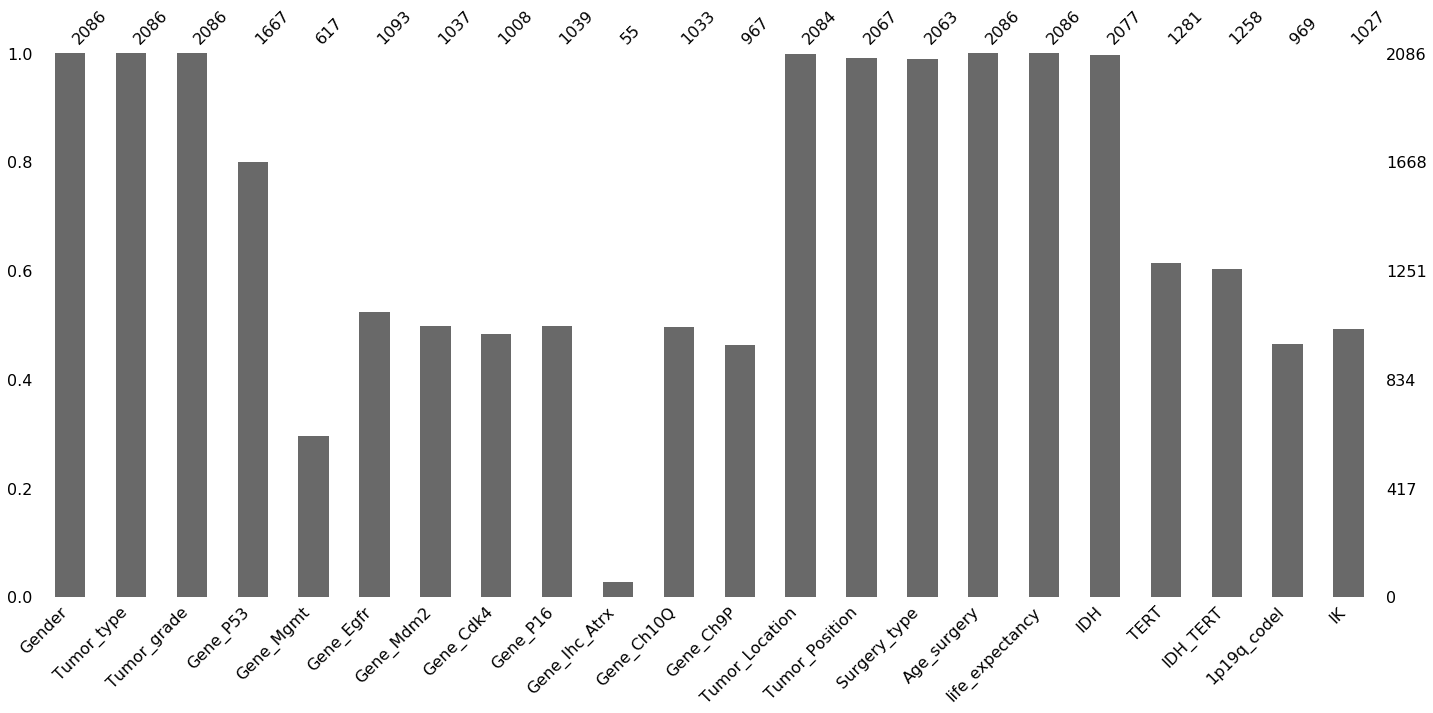

In [10]:
fig3 = msno.bar(df_md,inline=False,sort='descending')
plt.savefig(results_path + "null_counts_md")

**Heatmap of nullity correlations, a very important device to understand your pairwise missing data patterns:**
    
This can be useful for informing us of the missing data mechanism later
    1. -1 means that when one variable appears, the other definitely does not appear. 
    2. 0 means that variables have no influence on each other
    3. +1 means that when one variables appears, the other most definitely appears. 

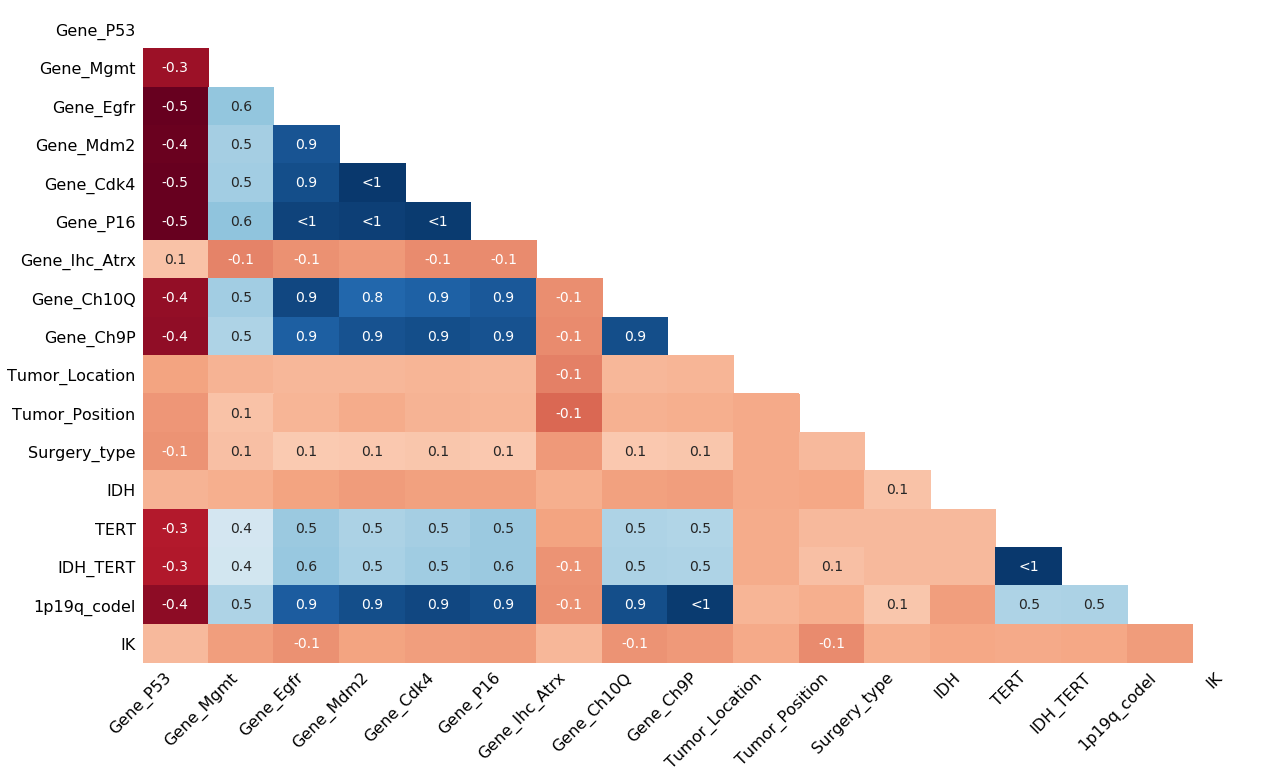

In [75]:
fig1 = msno.heatmap(df_md, inline=False)
plt.savefig(results_path + "md_heatmap_correlations")

Scipy dendogram outlining the correlations between certain variables. As seen before, the IDH_TERT and TERT appear together. 

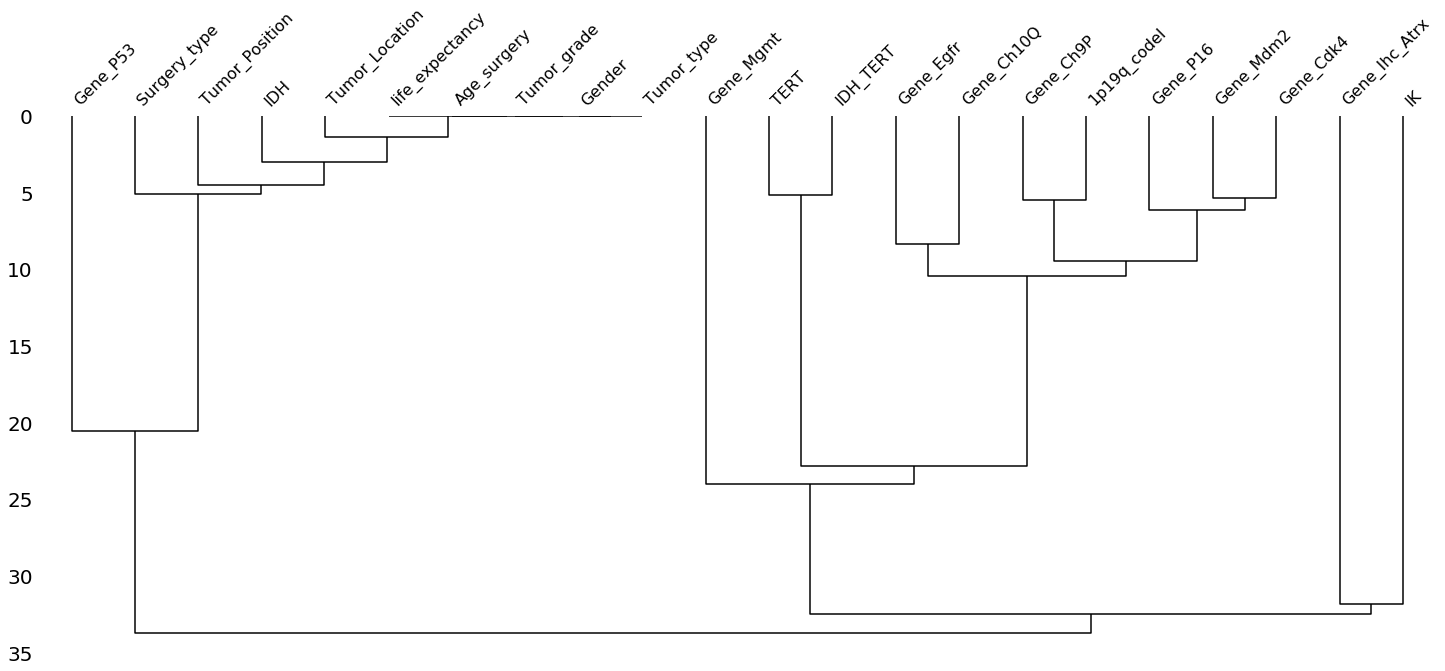

In [78]:
fig2 = msno.dendrogram(df_md,orientation='bottom', inline=False)
plt.savefig(results_path + "scipy_dendogram")

### TODO:  
    Data Exploration using dimensionality reduction techniques, i.e. TSNE 

In [ ]:
# Not currently working
tsne = manifold.TSNE(n_components=2,init='pca',random_state=0)

t0=time()
X_tsne = tsne.fit_transform(X)
helper.plot_embedding(X_tsne,"TSNE Embedding (time %.2fs)"%(time()-t0))

## 1. Amelia/MICE imputed dataset using no censoring (only patients with confirmed death)
* **Done**: GBM treatment is in a separate notebook
* **Done**: Understand what classes get confused
* Ongoing: Clinicians need interpretability if this is to be useful, see section 2 and GDocs
* Ongoing: Compare against Cox survival analysis model
* Ongoing: Explain why MICE over Amelia for our scenario

* Backlog: Run on missing dataset
* Backlog: TSNE visualization
* Backlog: Split the data into categories based on Alex's clustering 


## 2. IDEAS: 
* Plot predictor vs variables as pairplots and observe a few things. Reconcile them with Alex's exploration. Add all of them to the google doc.
    Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
    Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the   left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

## 3. Technicalities
* Categorical, no order - only used for visualization purposes
* Dummies
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

In [34]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')
DATA_CENSORING_MICE = os.path.join(IMC_basedir, 'data/imputed_dataset_with_censoring_26022018_MICE_original.csv')

Figure out the differences in datasets between censored and not censored

In [35]:
df1 = pd.read_csv(DATA_CENSORING_MICE)

In [40]:
df1.shape

(2635, 24)

In [14]:
labels = ["1.2 years","2.5years","more"]
cut_points = [400,900]

# Load the raw dataset
df = pd.read_csv(DATA_MICE_FILE)


df_standardized = df.copy(deep=True)

col_names = ['Age_surgery', 'IK']
features = df_standardized[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_standardized[col_names] = features


# Dummies dataset, used for analysis
df_dummies, labels = helper.process_dataset(df,labels,cut_points)
df_dummies_standardized, labels_standardized = helper.process_dataset(df_standardized, labels,cut_points)

# Label Encoded Dataset, used for visualization
df_encoded, le_dict = helper.label_encoder(df, labels, cut_points)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


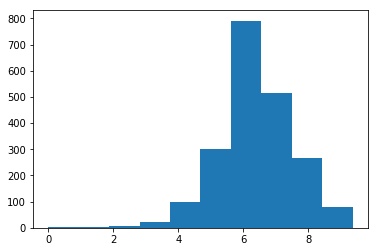

In [15]:
plt.hist(np.log(df_dummies.life_expectancy),bins =10);

In [16]:
# This is life expectancy in days
life = df['life_expectancy'].values

In [17]:
# Normalize data between with x_new = x - x.min()/(x.max() - x.min)
x_new = (life - life.mean())/life.std()
x_new

array([-0.75001024,  0.71737578, -0.48877379, ..., -0.67732461,
        0.44174613, -0.54850554])

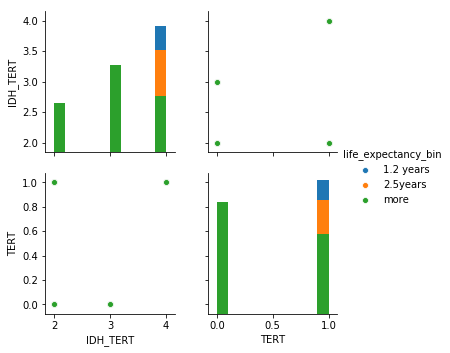

In [18]:
sns.pairplot(data=df_dummies,vars=tuple(["IDH_TERT","TERT"]),hue='life_expectancy_bin',diag_kind='hist');
#hue='life_expectancy',height=3,kind='scatter')
#g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

In [64]:
# Display all posibilities for dataframe
helper.display_values(df_dummies_standardized)

Number of values for attribute Gender: 2 -- [0 1]
Number of values for attribute Tumor_grade: 4 -- [1 2 3 4]
Number of values for attribute Age_surgery: 78
Number of values for attribute life_expectancy: 1283
Number of values for attribute TERT: 2 -- [0 1]
Number of values for attribute IDH_TERT: 3 -- [2 3 4]
Number of values for attribute IK: 11 -- [-5.15180489 -4.30676856 -3.46173224 -2.61669591 -1.85616321 -1.77165958
 -0.92662325 -0.08158692  0.76344941  1.18596757  1.60848574]
Number of values for attribute life_expectancy_bin: 3 -- ['1.2 years' '2.5years' 'more']
Number of values for attribute Gene_Egfr_AMPLIFIE: 2 -- [0 1]
Number of values for attribute Gene_Egfr_NORMAL: 2 -- [0 1]
Number of values for attribute Gene_Ch9P_GAIN: 2 -- [0 1]
Number of values for attribute Gene_Ch9P_NON PERTE: 2 -- [0 1]
Number of values for attribute Gene_Ch9P_PERTE: 2 -- [0 1]
Number of values for attribute Tumor_type_GBM: 2 -- [0 1]
Number of values for attribute Tumor_type_astrocytome: 2 -- [0 1

## Create training and validation/test (hold-out validation)

In [19]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, Y_train, X_test, Y_test = helper.get_train_test_data(df_dummies,random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1668, 53) (418, 53) (1668,) (418,)


/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,X1p19q_codel_0,X1p19q_codel_1,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,IDH_NC,IDH_mutant,IDH_wt,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé
1650,1,4,61,1,4,60,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0
397,1,3,34,0,3,70,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0


# Random Forest
* **Done**: Data standardization for the continuous variables - it's not necessary in this case.
* **Done**: Do Cross Validation with KFold
* **Done**: Random Forests
* **Done**: Tune learning rate? Tune max_depth? This was done by Paul
* **Done**: * Wide and Deep NN with Tensorflow - done in a separate notebook

* Backlog: AUC adapted for 3 classes needs to be double checked. Meanwhile, just use the confusion matrix
           This seems to be more complicated than previously thought. A lot of literature on what you should do about that 

In [70]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,X1p19q_codel_0,X1p19q_codel_1,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,IDH_NC,IDH_mutant,IDH_wt,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.00000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,0.619904,3.386091,54.202038,0.558153,3.330336,80.962230,0.338129,0.661871,0.067746,0.507194,0.42506,0.583933,0.084532,0.006595,0.003597,0.007794,0.121103,0.192446,0.871103,0.128897,0.437650,0.462830,0.046163,0.004796,0.048561,0.021583,0.365108,0.303957,0.309353,0.067146,0.773381,0.159472,0.303357,0.696643,0.231415,0.768585,0.498201,0.501799,0.928058,0.014388,0.003597,0.050360,0.003597,0.167266,0.565947,0.266787,0.215228,0.150480,0.634293,0.226019,0.773981,0.338729,0.661271
std,0.485556,0.809866,15.282010,0.496756,0.727795,11.862556,0.473215,0.473215,0.251385,0.500098,0.49450,0.493053,0.278268,0.080964,0.059886,0.087964,0.326345,0.394340,0.335186,0.335186,0.496246,0.498766,0.209901,0.069109,0.215013,0.145360,0.481605,0.460102,0.462365,0.250350,0.418769,0.366226,0.459846,0.459846,0.421863,0.421863,0.500147,0.500147,0.258470,0.119122,0.059886,0.218752,0.059886,0.373325,0.495781,0.442413,0.411104,0.357648,0.481772,0.418377,0.418377,0.473420,0.473420
min,0.000000,1.000000,8.000000,0.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,43.000000,0.000000,3.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,4.000000,55.000000,1.000000,3.000000,80.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1

In [21]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

### Baseline Logistic Regression Classifier
    Takes 1-2 minutes to finish
    We see that we get a good loss and score with a simple model

Quantify uncertainties on the classification 

In [41]:
l = np.array(labels)
base_lg = LogisticRegressionCV(Cs=100,penalty='l2',cv=5,multi_class='multinomial',random_state=random_states[1],max_iter=10000)
base_lg.fit(X_train,Y_train)
probas = base_lg.predict_proba(X_test)
error = log_loss(Y_test, probas)
print("For {0} class problem using base Logistic Regression --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_lg.score(X_test,Y_test), error))

For 3 class problem using base Logistic Regression --- Harsh Accuracy: 0.6076555023923444 and Logloss: 0.8466413680852197


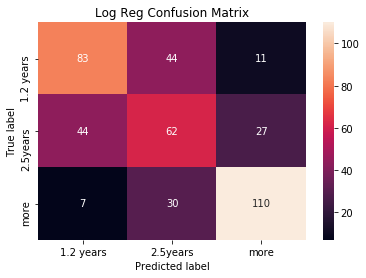

In [25]:
y_pred = base_lg.predict(X_test)
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l,title="Log Reg Confusion Matrix")
plt.savefig(results_path+"multi_log_reg")

### Lime Interpretability Model 

In [74]:
import lime
import lime.lime_tabular

In [102]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                feature_names=['Gender','Tumor_grade','Age_surgery','IK','TERT', 'IDH_TERT','Tumor_type_GBM'],
                categorical_features= [],categorical_names=[]
                                    
                                class_names=np.asarray(df_dummies.life_expectancy_bin.unique()), 
                                discretize_continuous=False)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [115]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.values[i], base_lg.predict_proba, num_features=2, top_labels=1)

In [116]:
exp.show_in_notebook(show_table=True, show_all=False)

### Baseline Random Forest Classifier 

In [26]:
l = np.array(labels)
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem using base Random Forest --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 3 class problem using base Random Forest --- Harsh Accuracy: 0.5956937799043063 and Logloss: 0.8817143549792303


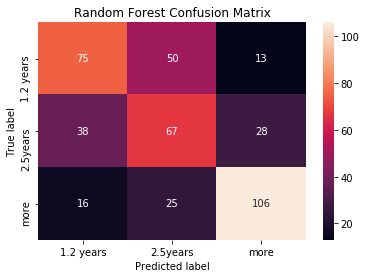

In [15]:
y_pred = base_rfc.predict(X_test)
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l,"Random Forest Confusion Matrix")

### Grid Search - 1h20min

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,500,1000,1500]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2,
                           scoring='neg_log_loss', cv = 5, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

In [18]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [19]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=80, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1233, verbose=0, warm_start=False)

In [ ]:
# Compare to previous approach - I don't think this one is better (Fix helper)
#df = pd.DataFrame.from_dict(grid_search.cv_results_) 
#helper.write_to_pickle(df,"RandomForest_CV_400estimators")

              precision    recall  f1-score   support

   1.2 years       0.60      0.59      0.59       138
    2.5years       0.46      0.45      0.45       133
        more       0.73      0.75      0.74       147

   micro avg       0.60      0.60      0.60       418
   macro avg       0.59      0.60      0.59       418
weighted avg       0.60      0.60      0.60       418

Accuracy: 0.6004784688995215
For 3 class problem using BEST RF Model --- Harsh Accuracy: 0.6004784688995215 and Logloss: 0.8529229867230415


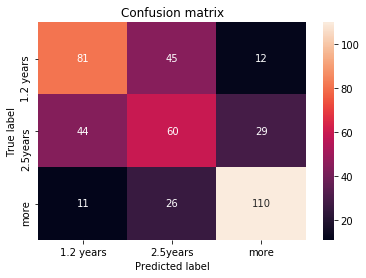

In [42]:
rfc=RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=80, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1233, verbose=0, warm_start=False)

rfc.fit(X_train, Y_train)

# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Plot Report
evaluation.plot_report(Y_test, l[y_pred], labels)
print("For {0} class problem using BEST RF Model --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    

In [42]:
y_pred = rfc.predict(X_test)

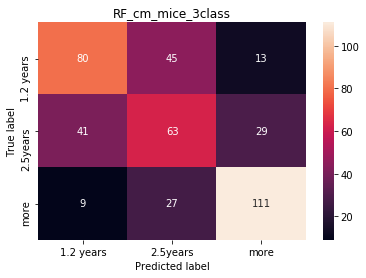

In [43]:
plt.figure()
evaluation.plot_confusion_matrix(confusion_matrix(Y_test, y_pred),
                          classes=labels, title='RF_cm_mice_3class')
plt.savefig(results_path+"RF_CM_MICE_3CLASS_GRIDSEARCH")

## Inspect confusion points
  * Here we are interested in what features the confused predictions had. For example, we look at the 9 patients in the corner that the prediction wrongly predicted to survive 1.2 years whereas they survived more than 3 years. We observe that age at surgery is between 60-64 with one at 39 and all of them had GBM type tumours. This is quite indicative of the fact that GBM and age are strong indicators of shorter lifespan. We investigate further into these features

In [44]:
confused12 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[1])
confused1more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[2])

confused21 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[0])
confused2more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[2])

confusedmore1 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[0])
confusedmore2 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[1])

In [83]:
confusedmore1

,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,IDH_NC,IDH_mutant,IDH_wt,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,X1p19q_codel_0,X1p19q_codel_1,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé
1494,0,4,63,0,3,90,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1952,1,4,39,0,3,70,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
287,1,4,60,0,3,70,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1551,0,4,64,0,3,80,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1357,0,4,64,1,4,90,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1034,1,4,64,1,4,100,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1724,0,4,62,0,3,80,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
357,0,4,62,1,4,70,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1771,0,4,61,1,4,70,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


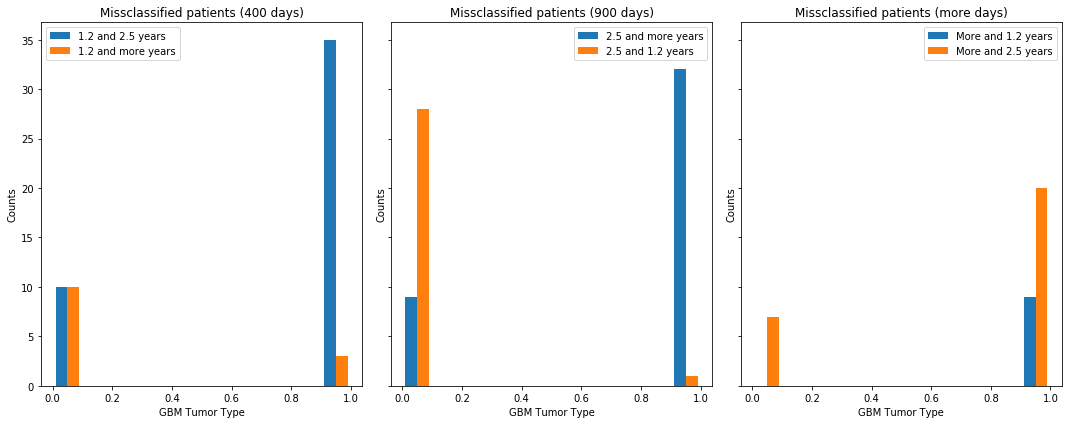

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15,6),sharey=True, sharex=True)
#ax.set_xlabel("GBM Tumor Type")
#ax.set_ylabel("Count")
#ax[0].hist(confused21.Tumor_type_GBM)
axes[0].hist([confused12.Tumor_type_GBM,confused1more.Tumor_type_GBM],label=['1.2 and 2.5 years', '1.2 and more years'])
axes[0].legend()
axes[0].set_title("Missclassified patients (400 days)")

axes[1].hist([confused21.Tumor_type_GBM,confused2more.Tumor_type_GBM],label=['2.5 and more years', '2.5 and 1.2 years'])
axes[1].legend()
axes[1].set_title("Missclassified patients (900 days)")

axes[2].hist([confusedmore1.Tumor_type_GBM,confusedmore2.Tumor_type_GBM],label=['More and 1.2 years', 'More and 2.5 years'])
axes[2].legend()
axes[2].set_title("Missclassified patients (more days)")


for ax in axes:
    ax.set_xlabel("GBM Tumor Type")
    ax.set_ylabel("Counts")

fig.tight_layout()
fig.savefig(results_path + "GBM histograms for missclassfied patients")

Another analysis of confused predictions and patients tumor types. Somewhat expected is that the algorithm missclassifies patients within the 1.2 and 2.5 years span that have GBM tumours. 

In [47]:
# Reconstruct the dataframes as in the beginning
cf12 = helper.from_dummies(confused12)
cf1more = helper.from_dummies(confused1more)

cf21 = helper.from_dummies(confused21)
cf2more = helper.from_dummies(confused2more)

cfmore1 = helper.from_dummies(confusedmore1)
cfmore2 = helper.from_dummies(confusedmore2)

In [48]:
cfmore1

,Gene_P53,IDH,Gene_Cdk4,Gene_Ch10Q,Tumor_Location,X1p19q_codel,Gene_P16,Gene_Ch9P,Gene_Egfr,Gene_Mdm2,Gene_Mgmt,Gene_Ihc,Tumor_type,Surgery_type,Tumor_Position,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK
0,NC,wt,NORMAL,PERTE,N,0,NORMAL,PERTE,AMPLIFIE,NORMAL,METHYLE,Maintien,GBM,partielle,D,0,4,63,0,3,90
1,NC,wt,NORMAL,NON PERTE,B,0,DELETE,NON PERTE,NORMAL,NORMAL,NON METHYLE,extinction,GBM,aucune,non précisé,1,4,39,0,3,70
2,NC,wt,NORMAL,PERTE,A,0,DELETE,NON PERTE,NORMAL,NORMAL,NON METHYLE,Maintien,GBM,exérèse,D,1,4,60,0,3,70
3,NC,wt,NORMAL,PERTE,A,0,NORMAL,PERTE,AMPLIFIE,NORMAL,NON METHYLE,Maintien,GBM,partielle,D,0,4,64,0,3,80
4,NC,wt,NORMAL,PERTE,A,0,DELETE,PERTE,AMPLIFIE,NORMAL,NON METHYLE,Maintien,GBM,biopsie,D,0,4,64,1,4,90
5,NC,wt,NORMAL,NON PERTE,A,0,DELETE,PERTE,AMPLIFIE,NORMAL,NON METHYLE,Maintien,GBM,partielle,G,1,4,64,1,4,100
6,NC,wt,AMPLIFIE,PERTE,A,0,NORMAL,PERTE,NORMAL,AMPLIFIE,NON METHYLE,Maintien,GBM,biopsie,G,0,4,62,0,3,80
7,NORMAL,wt,NORMAL,NON PERTE,A,0,NORMAL,NON PERTE,NORMAL,NORMAL,METHYLE,Maintien,GBM,exérèse,D,0,4,62,1,4,70
8,NC,wt,NORMAL,PERTE,A,0,NORMAL,PERTE,NORMAL,NORMAL,NON METHYLE,Maintien,GBM,biopsie,G,0,4,61,1,4,70


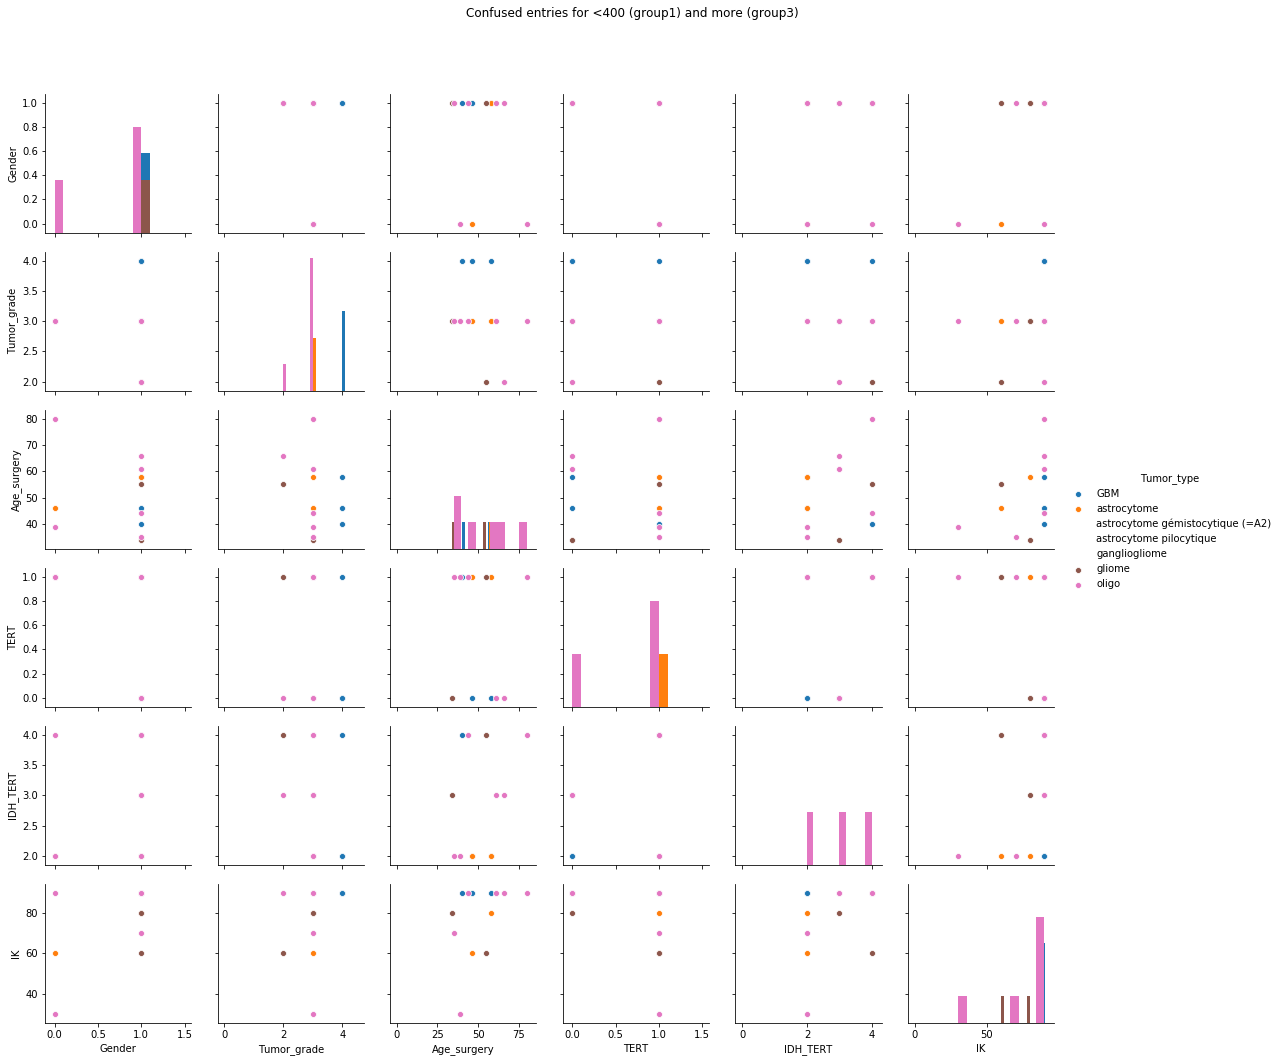

In [71]:
# Pairplot some of the variables
g1 = sns.pairplot(data=cf1more,hue='Tumor_type',vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],diag_kind='hist')
plt.subplots_adjust(top=0.9)
g1.fig.suptitle('Confused entries for <400 (group1) and more (group3)') 
g1.savefig(results_path + "1st-2nd Group GBM confused patients")

**Something happened in the pairplot method, please don't run this before is fixed to not replot wrongly as above**

Text(0.5,0.98,'Confused entries for <400 (group1) and <900 (group2)')

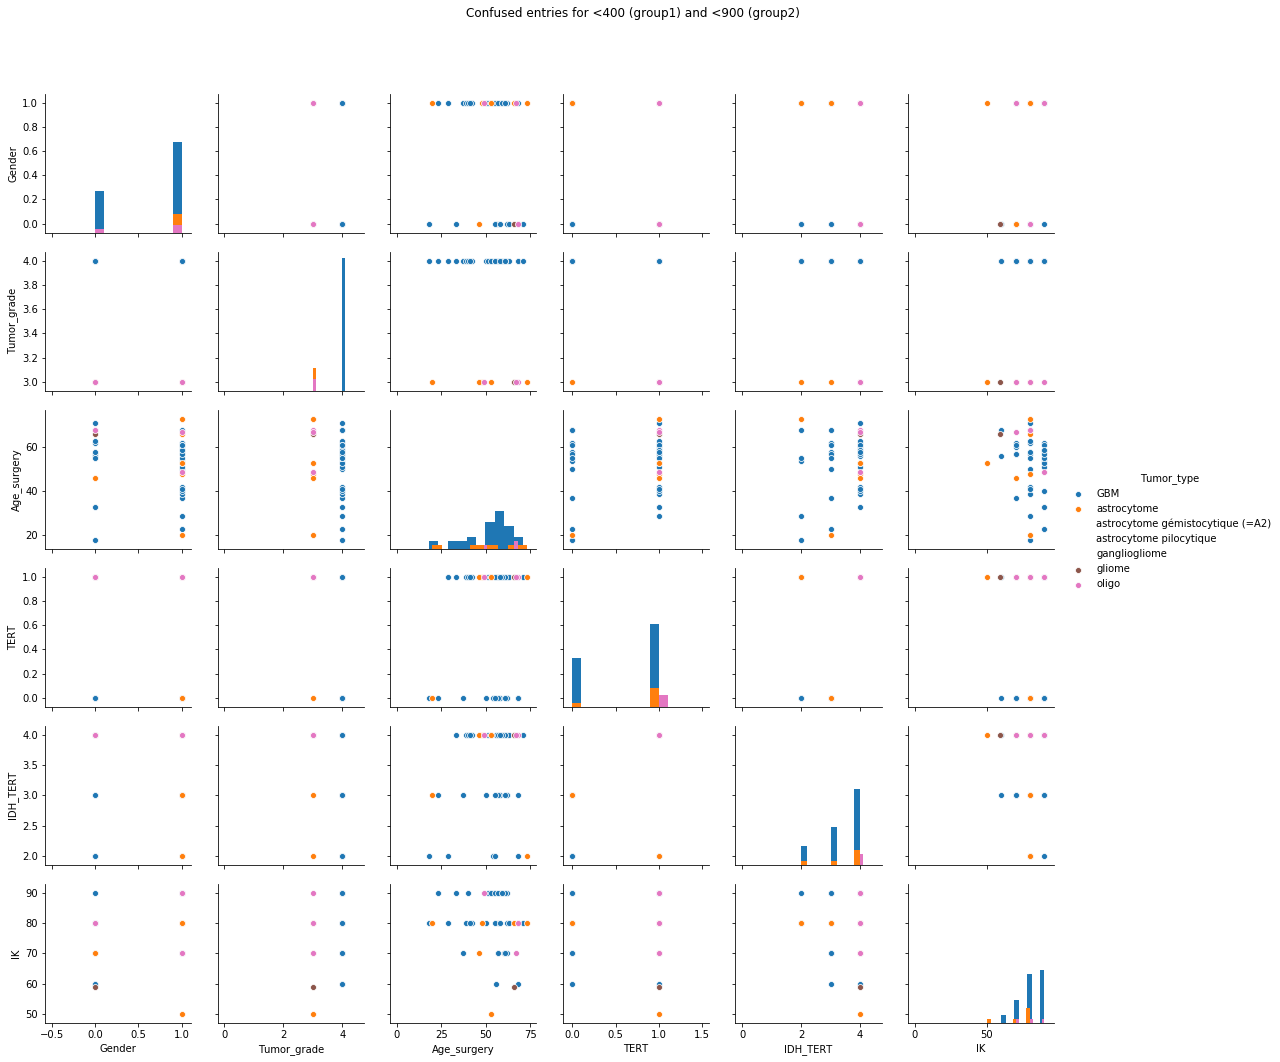

In [61]:
g2 = sns.pairplot(data=cf12,hue="Tumor_type",diag_kind='hist',vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"])
plt.subplots_adjust(top=0.9)
g2.fig.suptitle('Confused entries for <400 (group1) and <900 (group2)') 
#g2.savefig(results_path + "1st-3rd Group GBM confused patients")

Below we can see joint plots between the two groups based on various categories and the type of tumours present. We see that GBM is strongly present in most places where the algorithm got confused

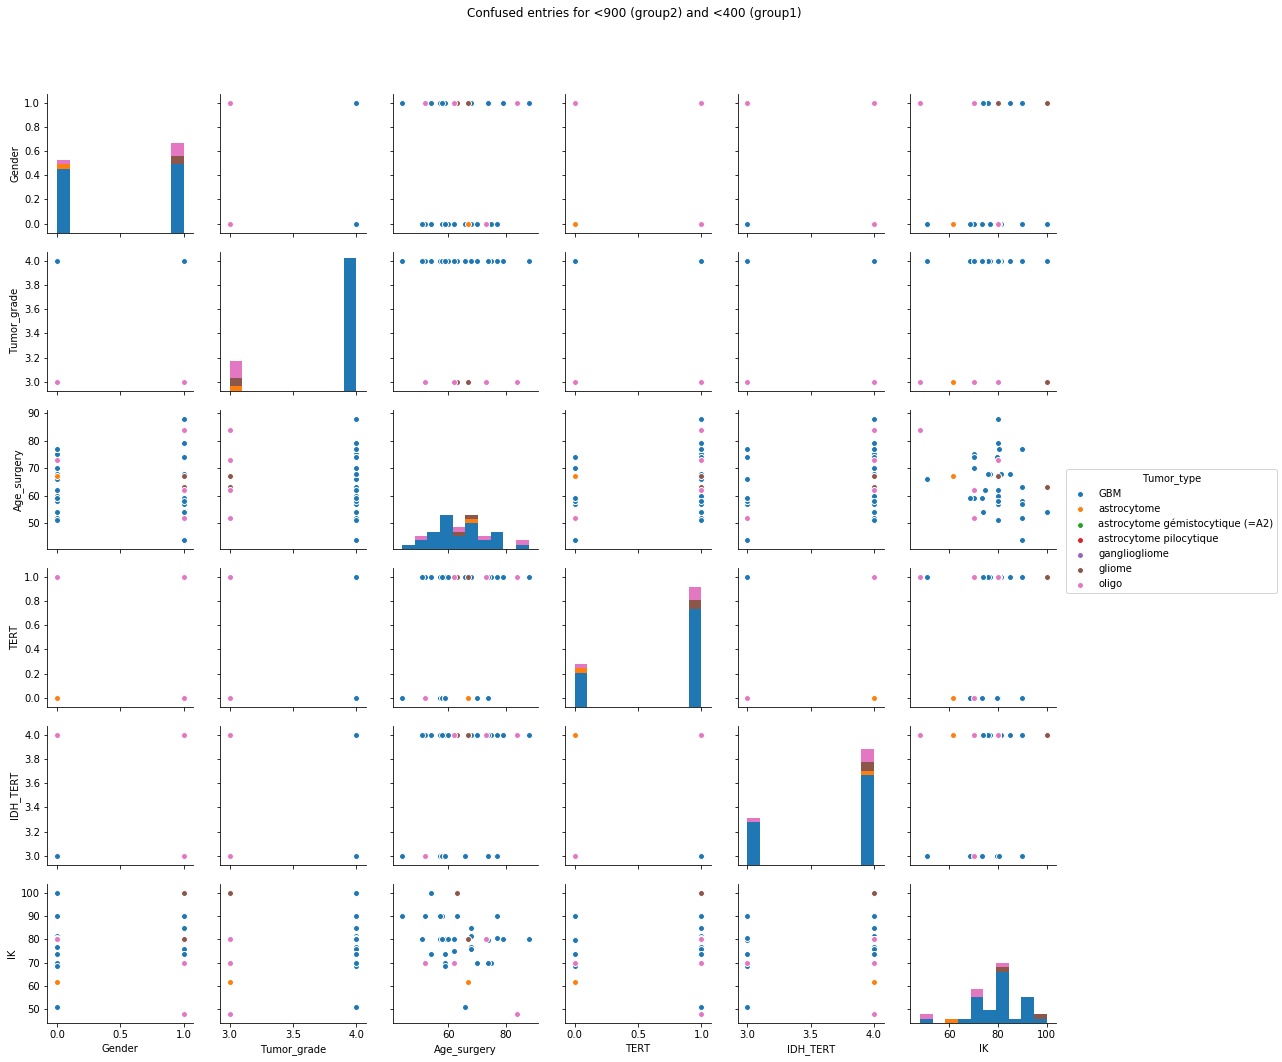

In [63]:
g3 = sns.pairplot(data=cf21,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g3.fig.suptitle('Confused entries for <900 (group2) and <400 (group1)') 
g3.savefig(results_path + "2st-1rd Group GBM confused patients")

Text(0.5,0.98,'Confused entries for <900 (group2) and more (group3)')

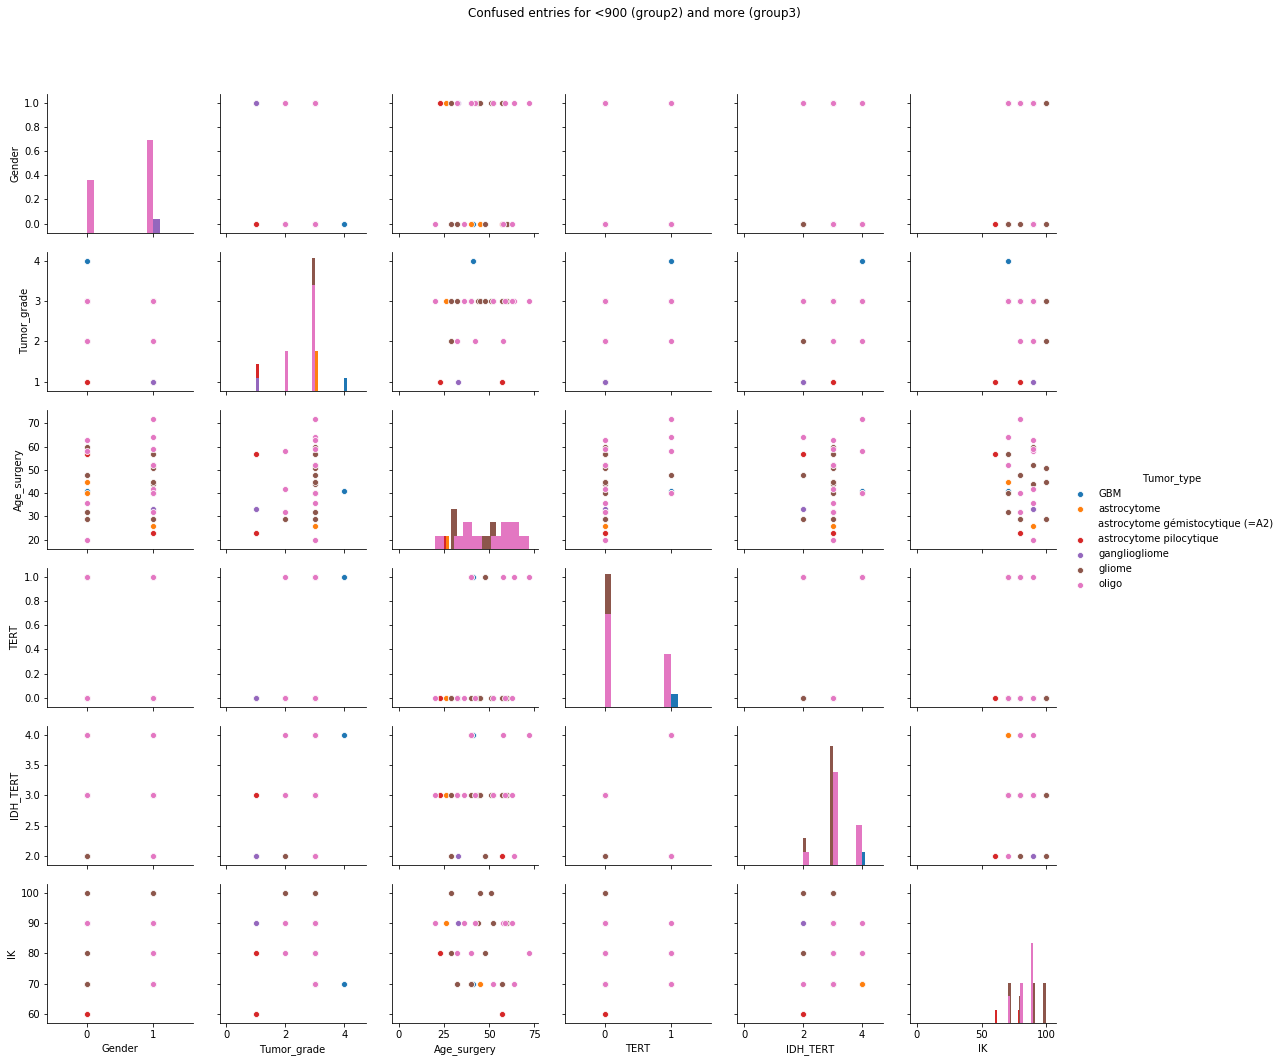

In [72]:
g4 = sns.pairplot(data=cf2more,hue="Tumor_type",vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],diag_kind='hist');
plt.subplots_adjust(top=0.9)
g4.fig.suptitle('Confused entries for <900 (group2) and more (group3)') 
#g4.savefig(results_path + "2st-3rd Group GBM confused patients")

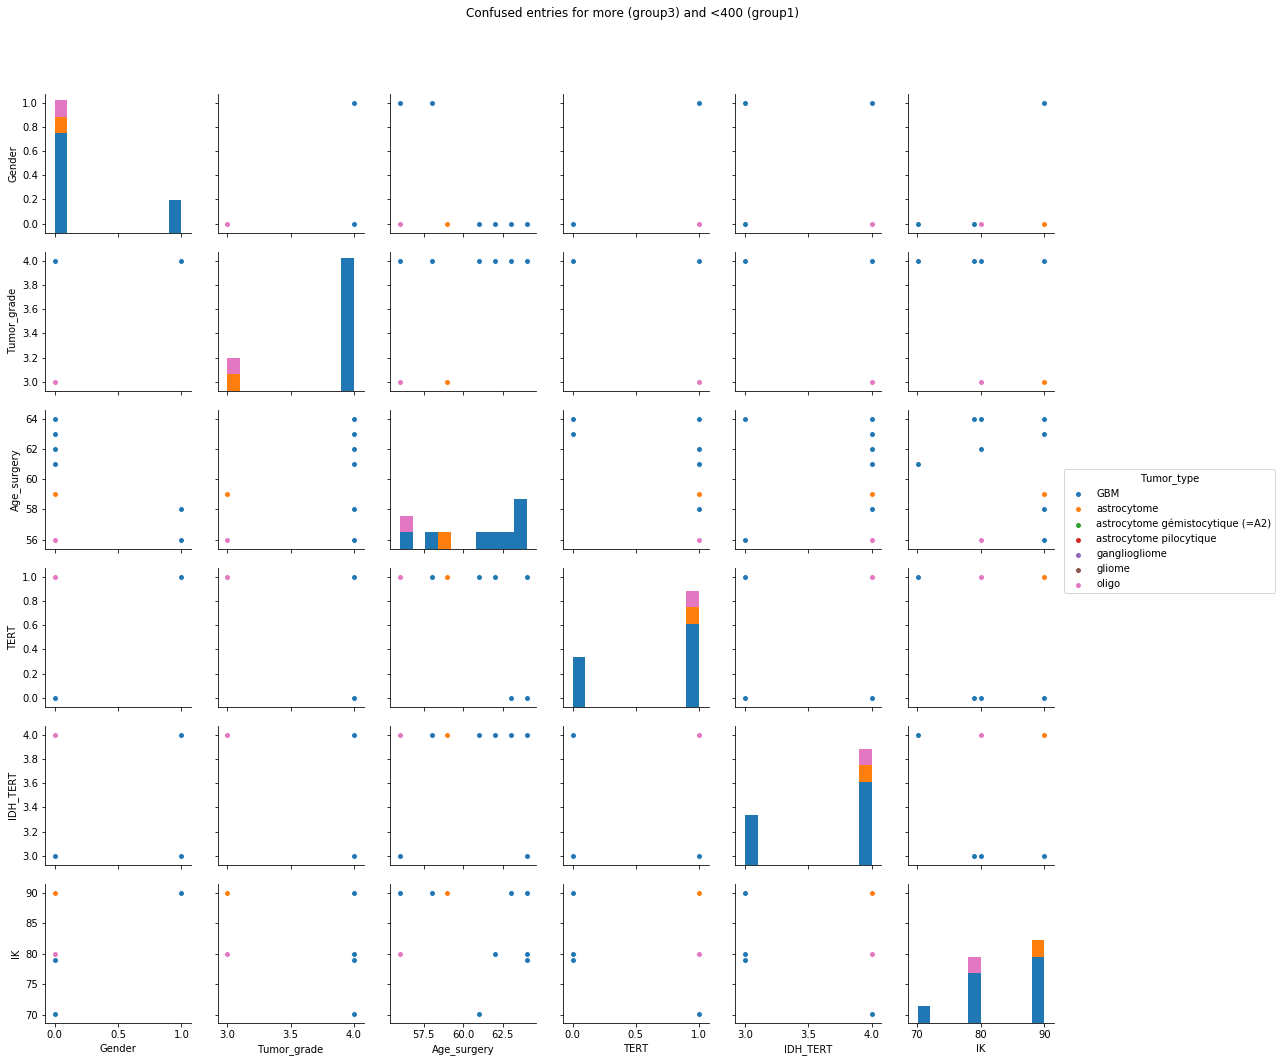

In [65]:
g5 = sns.pairplot(data=cfmore1,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g5.fig.suptitle('Confused entries for more (group3) and <400 (group1)') 
g5.savefig(results_path + "3rd-1st Group GBM confused patients")

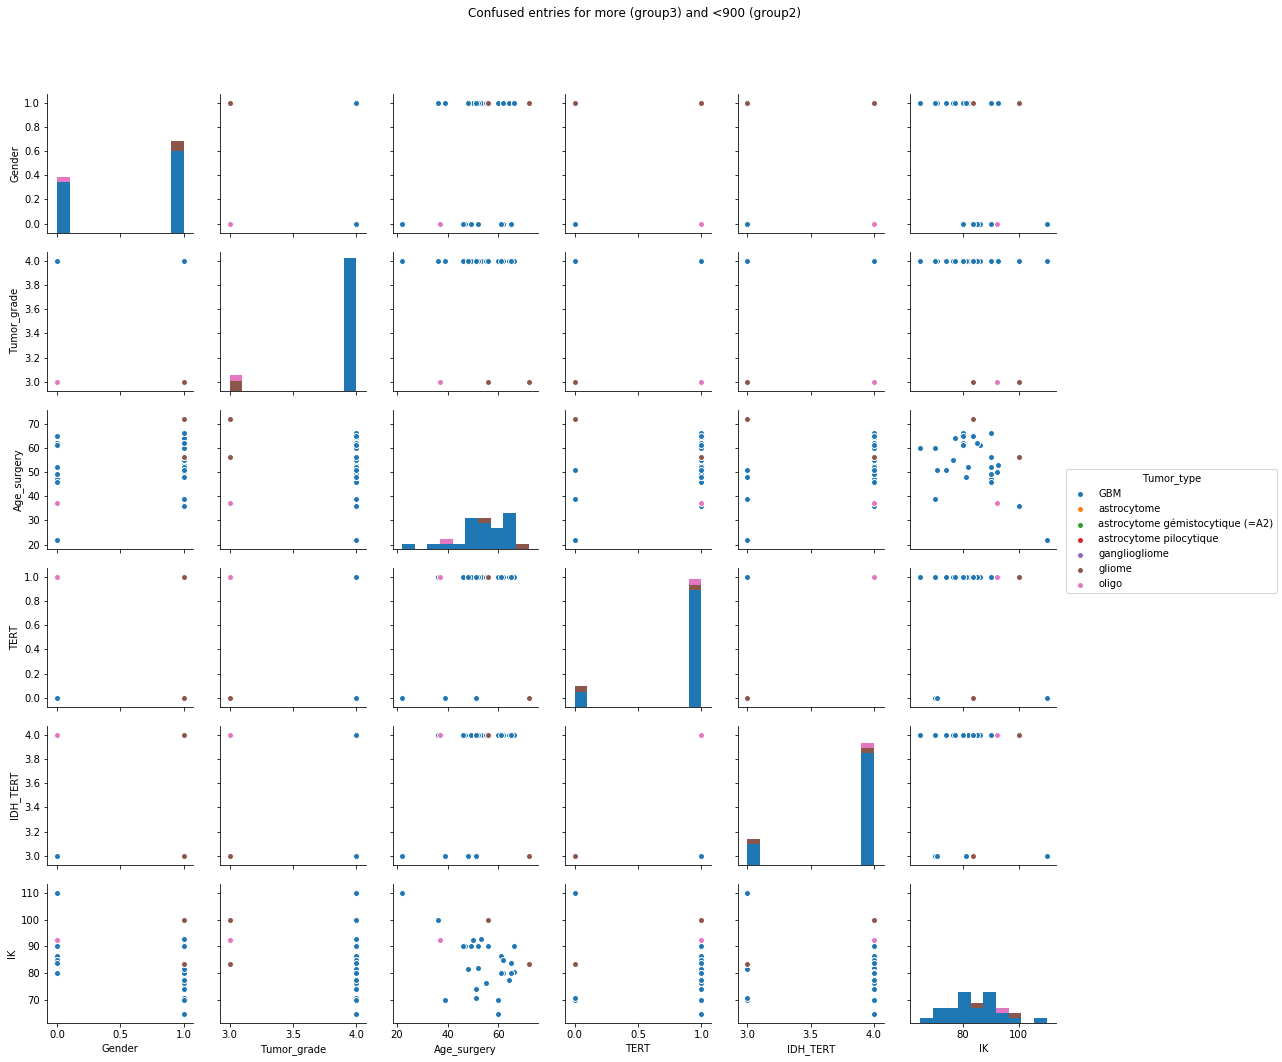

In [66]:
g6 = sns.pairplot(data=cfmore2,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g6.fig.suptitle('Confused entries for more (group3) and <900 (group2)') 
g6.savefig(results_path + "3rd-2nd Group GBM confused patients")

# XGBoost Gradient Boosting 

In [21]:
from xgboost import XGBClassifier

## Baseline XGBoost

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

    8months       0.37      0.55      0.44       119
   1.5years       0.19      0.20      0.19       133
   2.5years       0.25      0.12      0.16       116

avg / total       0.27      0.29      0.26       368

Accuracy: 0.28532608695652173


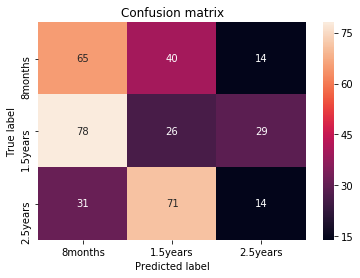

In [22]:
boost_model = XGBClassifier()
boost_model.fit(X_train, Y_train)
boost_model.score(X_test,Y_test)

probas = boost_model.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

evaluation.plot_report(Y_test, l[y_pred], labels)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


For 3 class problem --- Accuracy: 0.42934782608695654 and Logloss: 1.3272589974272389
             precision    recall  f1-score   support

    8months       0.39      0.50      0.44       119
   1.5years       0.28      0.29      0.28       133
   2.5years       0.24      0.16      0.19       116

avg / total       0.30      0.32      0.31       368

Accuracy: 0.3179347826086957


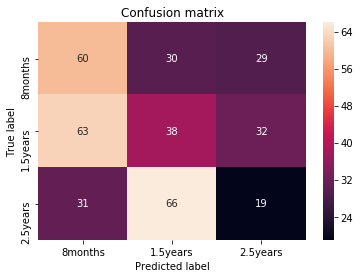

In [23]:
# Gradient Boosting classifiers based on validation/test
# What are the key aspects of tuning the XGBoost Tree
gbc = XGBClassifier(learning_rate= 0.03, 
                                 n_estimators=300,
                                 max_depth =30,                          
                                 random_state = 1123)
gbc.fit(X_train, Y_train)

# Accuracy
accuracy = gbc.score(X_test,Y_test)

# Error 
probas = gbc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    
evaluation.plot_report(Y_test, l[y_pred], labels)

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [ ]:
#plt.figure()
#evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
#plt.xlabel('Interpreted cluster label')
#plt.show()

In [32]:
#fig, ax = plt.subplots(1, 3, figsize=(15,10))

#ax[0].scatter(estimators_range, errors)
#ax[0].set_ylabel('Log-loss error on validation set')
#ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[1].scatter(estimators_range, accuracies)
#ax[1].set_ylabel('Accuracies on validation set')
#ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[2].scatter(estimators_range, roc_auc)
#ax[2].set_ylabel('AUC on validation set')
#ax[2].set_xlabel('Number of estimators for Random Forest Classifier');


## Miscellaneous - Exporting data to a tree style graph for interpretation

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

########### 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)